In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
!pip install tweet-preprocessor
# !pip install catboost
# !pip install xgboost

In [25]:
import os

os.chdir('/content/gdrive/My Drive/CODE-MIXED-SENTI')
os.getcwd()

'/content/gdrive/My Drive/CODE-MIXED-SENTI'

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter


import preprocessor as p
p.set_options(p.OPT.EMOJI, p.OPT.SMILEY)
# p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.SMILEY, p.OPT.NUMBER)

In [27]:
data_path = 'data'

In [28]:
def read_file(root_dir, train_file, dev_file):
  train_data = pd.read_csv(os.path.join(root_dir, train_file), encoding='utf-8', sep='\t')
  dev_data = pd.read_csv(os.path.join(root_dir, dev_file), encoding='utf-8', sep='\t')
  return train_data, dev_data


In [29]:
mal_train_df, mal_dev_df = read_file(data_path, 'malayalam_train.tsv', 'malayalam_dev.tsv')
# mal_train_df, mal_dev_df = read_file(data_path, 'tamil_train.tsv', 'tamil_dev.tsv')


In [30]:
train_text = mal_train_df['text']
train_label = mal_train_df['category']

dev_text = mal_dev_df['text']
dev_label = mal_dev_df['category']


In [31]:
print(train_text.head())

0               hoo mammokka police vesham aaha anthas
1       Oru rekshayum illa...kidilam kannu nananjupoyi
2                            Ikka     waiting.........
3               Raju Ettante Oro Shorttum Ijathi ppwli
4     Ettan fansil netti poya aarenkilum undo?    #...
Name: text, dtype: object


Counter({'Positive ': 2022, 'unknown_state ': 1344, 'not-malayalam ': 647, 'Negative ': 549, 'Mixed_feelings ': 289})


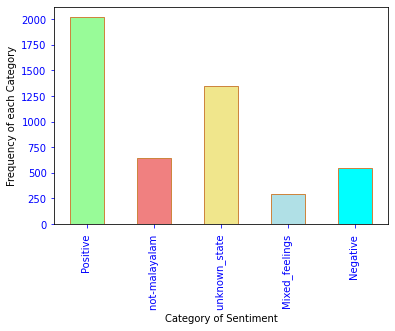

In [32]:
counter = Counter(train_label)
print(counter)

plt.ylabel('Frequency of each Category')
plt.xlabel('Category of Sentiment')

s = pd.Series(list(counter.values()), index = list(counter.keys()) )

ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='blue')

s.plot.bar(color=['palegreen', 'lightcoral', 'khaki', 'powderblue', 'cyan'], edgecolor='peru')
plt.show()

In [33]:
# train_text = train_text.apply(lambda x: p.clean(x))
# dev_text = dev_text.apply(lambda x: p.clean(x))

all_text = train_text.to_list()+dev_text.to_list()

In [34]:

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    max_features=10000)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 6),
    max_features=30000)


In [35]:
# build Vocabulary and Transform raw input to features
from scipy.sparse import hstack, vstack

word_vectorizer.fit(all_text)
char_vectorizer.fit(all_text)

# train_word_feat = word_vectorizer.transform(train_text)
# dev_word_feat = word_vectorizer.transform(dev_text)

# train_char_feat = char_vectorizer.transform(train_text)
# dev_char_feat = char_vectorizer.transform(dev_text)

# train_x = hstack([train_word_feat, train_char_feat])
# dev_x = hstack([dev_word_feat, dev_char_feat])


TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=1, ngram_range=(2, 6), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [36]:
# # from sklearn.model_selection import GridSearchCV
# # parameters = {'booster':('gbtree', 'gblinear', 'dart'), 'max_depth':[3, 4, 5]}
# # xgb = XGBClassifier()
# # clf = GridSearchCV(xgb, parameters, cv=10, verbose=10)
# # clf.fit(train_x, train_label)


# # xgb = XGBClassifier(booster='gbtree', max_depth=5)
# xgb = LogisticRegression(class_weight='balanced')

# # xgb = CatBoostClassifier(verbose=0, n_estimators=100)
# xgb.fit(train_x, train_label)

# # xgb1 = XGBClassifier(booster='dart', max_depth=5)
# # xgb1.fit(train_x, train_label)

In [37]:
# dev_predict = xgb.predict(dev_x)

# cm = confusion_matrix(dev_label, dev_predict)
# print(cm)
# columns = index = train_label.unique()

# cm_df = pd.DataFrame(cm, columns, index)                  
# plt.figure(figsize=(10,6))
# sns.heatmap(cm_df, annot=True)
# plt.savefig('heatmap.jpg')

# print(classification_report(dev_label, dev_predict, digits=4))
# print(accuracy_score(dev_label, dev_predict))


# ** *This cell is testing cell, used for applying stratified cross validation to avoid imbalancing issues.* **

In [43]:
#

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


le = preprocessing.LabelEncoder()

x_data, y_data = train_text.to_list()+dev_text.to_list(), train_label.to_list()+dev_label.to_list()
x_idx = [idx for idx, _ in enumerate(x_data)]
le.fit(y_data)
y_idx = le.transform(y_data)

skf = StratifiedKFold(n_splits=10)


for train_index, test_index in skf.split(x_idx, y_idx):
  X_train = [x_data[x_idx[idx]] for idx in train_index]
  X_test = [x_data[x_idx[idx]] for idx in test_index]

  y_train = [list(le.inverse_transform([y_idx[idx]]))[0] for idx in train_index]
  y_test = [list(le.inverse_transform([y_idx[idx]]))[0] for idx in test_index]

  train_word_feat = word_vectorizer.transform(X_train)
  train_char_feat = char_vectorizer.transform(X_train)

  test_word_feat = word_vectorizer.transform(X_test)
  test_char_feat = char_vectorizer.transform(X_test)

  X_train = hstack([train_word_feat, train_char_feat])
  X_test = hstack([test_word_feat, test_char_feat])

 # class weight parameters work well for Malayalam LR model, rather than Tamil LR model-- class_weight='balanced'
  # lr = LogisticRegression(class_weight='balanced')
  # lr = xgb = CatBoostClassifier(verbose=0, n_estimators=100)
  lr = xgb = XGBClassifier(booster='gbtree', max_depth=5)

  
  
  lr.fit(X_train, y_train)

  dev_predict = lr.predict(X_test)

  cm = confusion_matrix(y_test, dev_predict)
  print(cm)
  # columns = index = train_label.unique()

  # cm_df = pd.DataFrame(cm, columns, index)                  
  # plt.figure(figsize=(10,6))
  # sns.heatmap(cm_df, annot=True)
  # plt.savefig('heatmap.jpg')

  print(classification_report(y_test, dev_predict, digits=4))
  print(accuracy_score(y_test, dev_predict))


[[ 10   1  12   2   9]
 [  1  29  18   2  10]
 [  2   4 187   4  28]
 [  0   0  12  55   4]
 [  0   6  53  12  79]]
                 precision    recall  f1-score   support

Mixed_feelings      0.7692    0.2941    0.4255        34
      Negative      0.7250    0.4833    0.5800        60
      Positive      0.6631    0.8311    0.7377       225
 not-malayalam      0.7333    0.7746    0.7534        71
 unknown_state      0.6077    0.5267    0.5643       150

       accuracy                         0.6667       540
      macro avg     0.6997    0.5820    0.6122       540
   weighted avg     0.6705    0.6667    0.6544       540

0.6666666666666666
[[ 10   0  16   2   5]
 [  1  30  23   1   5]
 [  1   3 193   6  22]
 [  0   0  10  52   9]
 [  1   4  33   8 104]]
                 precision    recall  f1-score   support

Mixed_feelings      0.7692    0.3030    0.4348        33
      Negative      0.8108    0.5000    0.6186        60
      Positive      0.7018    0.8578    0.7720       225
 not

In [39]:
#Saving model

with open('xgboostWord.model', 'wb') as picklefile:
    pickle.dump(xgb, picklefile)

NameError: ignored

In [ ]:
# Loading saved model for predictions

with open('xgboostWord.model', 'rb') as training_model:
    model = pickle.load(training_model)



# Open test file with Pandas to perform cleaning and tf-idf.
test_data = pd.read_csv(os.path.join(data_path, 'malayalam_test.csv'), encoding='utf-8', sep=',')

test_id = test_data['id']
test_text = test_data['text']
test_text = test_text.apply(lambda x: p.clean(x))

test_x = word_vectorizer.transform(test_text)

test_pred_label = model.predict(test_x)

In [ ]:
print(test_pred_label[:10])

In [ ]:
test_label = pd.DataFrame(test_pred_label, index=None, columns=['label'])

pd.concat([test_id, test_data['text'], test_label], axis=1).to_csv('malayalam_test_pred.tsv', sep='\t', index=False)
